In [1]:
# Imports

import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,Concatenate,Add,Activation,MaxPooling2D,AveragePooling2D,Flatten
import keras.backend as K

from sklearn import preprocessing as pp

from sklearn.cluster import KMeans,MeanShift
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import BayesianRidge,Lasso,LinearRegression,SGDClassifier,SGDRegressor
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor,RadiusNeighborsClassifier,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.manifold import Isomap,TSNE
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.neural_network import BernoulliRBM,MLPClassifier,MLPRegressor
from sklearn.decomposition import FactorAnalysis,KernelPCA,PCA,MiniBatchSparsePCA,FastICA
from sklearn.preprocessing import CategoricalEncoder,KBinsDiscretizer,LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler

from xgboost import XGBClassifier,XGBRegressor

import pickle,h5py,json

import pandas_datareader as pdr
import urllib
from bs4 import BeautifulSoup
import iexfinance as iex
from iexfinance.stocks import get_historical_data
from scipy.signal import resample,correlate
from scipy import fftpack

warnings.filterwarnings('ignore')
sns.set()
plt.xkcd()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def nanmean(x):
    m = 0
    ctr = 0
    for k in x:
        if np.isnan(k): continue
        m += k
        ctr +=1
    m /= ctr
    return m

In [3]:
def predict_series(xtrain,lookback=5,num_epochs=5):
    
    S = []
    for x in xtrain:
        for k in range(len(x)-lookback):
            S.append(x[k:k+lookback])
    S = np.stack(S,axis=0)

    X = S[:,:-1].reshape(-1,lookback-1,1)
    y = S[:,-1]

    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,shuffle=True)

    lstm0 = LSTM(units=75,activation=tf.nn.relu,return_sequences=False,return_state=False)
    dropout0 = Dropout(rate=0.2)
    dense0 = Dense(units=50,activation=tf.nn.relu)
    dense1 = Dense(units=1,activation=tf.nn.relu)

    in0 = Input(shape=(Xtrain.shape[1],1,))
    x = lstm0(in0)
    x = dropout0(x)
    x = dense0(x)
    out0 = dense1(x)

    model = Model(in0,out0)
    model.compile(optimizer='adam',loss=tf.losses.mean_squared_error,metrics=['accuracy'])
    model.fit(Xtrain,ytrain,batch_size=3,epochs=num_epochs,validation_split=0.1)
    evalstats = model.evaluate(Xtest,ytest)
    
    return model,evalstats

In [4]:
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2017,1,1)

with open('Documents\stock_symb.txt','r') as f:
    lines = f.readlines()
content = [line.strip() for line in lines]
tickers = [content[i] for i in list(np.random.permutation(np.arange(len(content))))]

ticker_set = tickers[:50]
print_progress = 10

DATA = []
ctr = 0
for ticker in ticker_set:

    if ctr%print_progress==0: print('Processing %d/%d'%(ctr,len(ticker_set)))
    ctr += 1
    try:
        df = get_historical_data(ticker,start=start_date,end=end_date,output_format='pandas')
    except:
        continue
    data = df['open'].values
    DATA.append(data)

Processing 0/50
Processing 10/50
Processing 20/50
Processing 30/50
Processing 40/50


In [5]:
# First project: Fill in NaNs

In [6]:
datalen = [len(data) for data in DATA]
most_common_length = max(set(datalen),key=datalen.count)

xtrain = [data for data in DATA if np.sum(np.isnan(data))==0 and len(data)==most_common_length]
xuse = [data for data in DATA if np.sum(np.isnan(data))!=0]

In [7]:
df = pd.DataFrame(columns={'lookback','MSE','Accuracy','model'})
df['lookback'] = [2,3,5,10,25,50]

for c_lookback in df['lookback'].values:
    c_model,c_eval = predict_series(xtrain,lookback=c_lookback)
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='MSE',value=c_eval[0])
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='Accuracy',value=c_eval[1])
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='model',value=c_model)

Train on 10843 samples, validate on 1205 samples
Epoch 1/5
10843/10843 [==============================] - 12s 1ms/step - loss: 85.1743 - acc: 5.5335e-04 - val_loss: 1.6295 - val_acc: 0.0017
Epoch 2/5
10843/10843 [==============================] - 11s 1ms/step - loss: 38.7595 - acc: 3.6890e-04 - val_loss: 1.8146 - val_acc: 0.0041
Epoch 3/5
10843/10843 [==============================] - 11s 1ms/step - loss: 33.0304 - acc: 8.3003e-04 - val_loss: 27.7903 - val_acc: 0.0000e+00
Epoch 4/5
10843/10843 [==============================] - 12s 1ms/step - loss: 38.1702 - acc: 6.4558e-04 - val_loss: 88.7609 - val_acc: 0.0000e+00
Epoch 5/5
3012/3012 [==============================] - 0s 63us/step
Train on 10821 samples, validate on 1203 samples
Epoch 1/5
10821/10821 [==============================] - 15s 1ms/step - loss: 76.8179 - acc: 5.5448e-04 - val_loss: 19.9375 - val_acc: 0.0000e+00
Epoch 2/5
10821/10821 [==============================] - 14s 1ms/step - loss: 30.4074 - acc: 0.0010 - val_loss: 79

In [11]:
xfull = xuse[1].copy()

lookback = 3
model = df[df['lookback']==lookback]['model'].values[0]

nanpos = np.where(np.isnan(xfull))[0]
for p in nanpos:
    x = xfull[p-lookback+1:p].reshape(-1,lookback-1,1)
    ypred = model.predict(x)
    xfull[p] = ypred

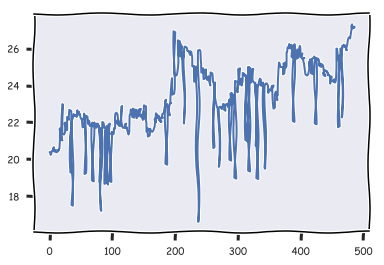

In [12]:
plt.plot(xfull)

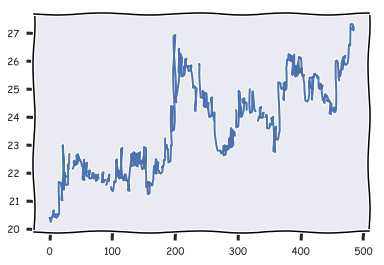

In [13]:
plt.plot(xuse[1])

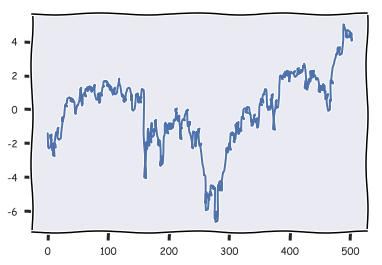

In [17]:
plt.plot(xtrain[0]-nanmean(xtrain[0]))